In [1]:
from tqdm import tqdm
import scipy
import rdata
from sklearn.model_selection import train_test_split
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from optax import adam, chain, clip

from numpyro import distributions as dist

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy import linalg


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_x64()

In [2]:
# UCI regression datasets with less than 1000 observations

from uci_datasets import small_datasets, intermediate_datasets, all_datasets, large_datasets


for name,(n_observations, n_dimensions) in all_datasets.items():
        print(name, (n_observations, n_dimensions))


3droad (434874, 3)
autompg (392, 7)
bike (17379, 17)
challenger (23, 4)
concreteslump (103, 7)
energy (768, 8)
forest (517, 12)
houseelectric (2049280, 11)
keggdirected (48827, 20)
kin40k (40000, 8)
parkinsons (5875, 20)
pol (15000, 26)
pumadyn32nm (8192, 32)
slice (53500, 385)
solar (1066, 10)
stock (536, 11)
yacht (308, 6)
airfoil (1503, 5)
autos (159, 25)
breastcancer (194, 33)
buzz (583250, 77)
concrete (1030, 8)
elevators (16599, 18)
fertility (100, 9)
gas (2565, 128)
housing (506, 13)
keggundirected (63608, 27)
machine (209, 7)
pendulum (630, 9)
protein (45730, 9)
servo (167, 4)
skillcraft (3338, 19)
sml (4137, 26)
song (515345, 90)
tamielectric (45781, 3)
wine (1599, 11)


In [3]:
small_datasets

['challenger',
 'fertility',
 'slump',
 'automobile',
 'servo',
 'cancer',
 'hardware',
 'yacht',
 'autompg',
 'housing',
 'forest',
 'stock',
 'pendulum',
 'energy',
 'concrete',
 'solar',
 'airfoil',
 'wine']

In [4]:
intermediate_datasets

['gas',
 'skillcraft',
 'sml',
 'parkinsons',
 'pumadyn',
 'poletele',
 'elevators',
 'kin40k',
 'protein',
 'kegg',
 'keggu',
 'ctslice']

In [5]:
large_datasets

['3droad', 'song', 'buzz', 'electric']

# Choose dataset

In [26]:
from uci_datasets import Dataset
# data = Dataset('yacht')
# data = Dataset('pendulum')
# data = Dataset('airfoil')
# data = Dataset("kin40k")
# data = Dataset("challenger")
# data = Dataset("wine")
# data = Dataset("concrete")
# data = Dataset("protein")
# data = Dataset("electric")
# data = Dataset("autos")
# data = Dataset("sml")
data = Dataset("fertility")



X_train, y_train, X_test, y_test = data.get_split(split=1)  # there are 10 different trainning-test splits

y_train = y_train.squeeze(); y_test = y_test.squeeze()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

fertility dataset, N=100, d=9


((90, 9), (10, 9), (90,), (10,))

In [27]:
%%script true   # do not run this cell
# This cell was for generating the data and use it in Matlab
import csv

Xtrain = X_train
Xtest = X_test
Ytrain = y_train.reshape(y_train.shape[0],1)
Ytest = y_test.reshape(y_test.shape[0],1)

with open('Xtrain.txt', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(Xtrain)
with open('Xtest.txt', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(Xtest)
with open('Ytrain.txt', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(Ytrain)
with open('Ytest.txt', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(Ytest)    

In [29]:
# print( X_train.max(0))
# print(X_train.min(0))
# print( X_test.max(0))
# print(X_test.min(0))

# print( X_train.mean(0), X_train.var(0))
# print( X_test.mean(0), X_test.var(0))

print("mean train inputs: ",  X_train.mean(0))
print("mean test inputs: ", X_test.mean(0))
print("mean together inputs: ",np.vstack([X_train,X_test]).mean(0))
print("std together inputs: ",np.vstack([X_train,X_test]).std(0))

print("mean together/std together ",np.vstack([X_train,X_test]).mean(0)/np.vstack([X_train,X_test]).std(0))

mean train inputs:  [-0.00154444 -0.00577778 -0.00333333 -0.04       -0.02111111 -0.00111111
  0.00577778  0.01666667  0.00222222]
mean test inputs:  [ 0.0139  0.052   0.03    0.36    0.19    0.01   -0.052  -0.15   -0.02  ]
mean together inputs:  [-2.77555756e-17  1.11022302e-18  0.00000000e+00  3.99680289e-17
  1.77635684e-17  4.60742555e-17 -1.11022302e-18  2.66453526e-17
 -6.66133815e-17]
std together inputs:  [0.79273185 0.1207104  0.33630343 0.49638695 0.49989999 0.57784081
 0.16666133 0.80467385 0.32496154]
mean together/std together  [-3.50125651e-17  9.19741008e-18  0.00000000e+00  8.05178888e-17
  3.55342443e-17  7.97352053e-17 -6.66155132e-18  3.31132330e-17
 -2.04988511e-16]


In [14]:
print("mean: ", y_train.mean(), ", std: ", y_train.std())
print("mean: ", y_test.mean(), ", std: ", y_test.std())

print("mean together: ",np.vstack([y_train.reshape(-1,1),y_test.reshape(-1,1)]).mean())
print("std together: ",np.vstack([y_train.reshape(-1,1),y_test.reshape(-1,1)]).std())

print((y_test - y_train.mean(0)).mean(0))

print("mean together/std together: ",np.vstack([y_train.reshape(-1,1),y_test.reshape(-1,1)]).mean()/
      np.vstack([y_train.reshape(-1,1),y_test.reshape(-1,1)]).std())

mean:  -0.020616621434911265 , std:  6.928130624191927
mean:  0.18483509933774833 , std:  6.602323249066603
mean together:  2.4236739853569424e-05
std together:  6.8963703006760095
0.20545172077265955
mean together/std together:  3.514419730505719e-06


In [7]:
# Normalize data to unit interval
X_train_max = X_train.max(0)
X_train_min = X_train.min(0)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

print(X_train.max(0))
print(X_train.min(0))

print(X_test.max(0))
print(X_test.min(0))

[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]


In [9]:
# standardize data to zero mean and unit variance
y_train_mean = y_train.mean(0)
y_train_std = y_train.std(0)

y_train = (y_train - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std

print(y_train.mean(0), y_train.std(0))
print(y_test.mean(0), y_test.std(0))

0.0 1.0
-0.3548831845234304 0.9732266594583571


# GP (not random-feature)

In [10]:
# squared exponential kernel with diagonal noise term
def SE_kernel(X, Z, sigf, length, sign, jitter=1.0e-6, include_noise=True, ard = False):
    a = X.shape[0]
    b = Z.shape[0]

    if len(X.shape) < 2:
        deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0) # when X.shape = (N,)
    else:
        aux = (X[:, None,:] - Z[None,:,:]) # when X.shape = (N,D)
        if ard:
            length = jnp.broadcast_to(length,(aux.shape))
            deltaXsq = jnp.sum( jnp.power( aux / length, 2.0 ) , axis=2) 
        else:
            deltaXsq = jnp.sum( jnp.power((X[:, None,:] - Z[None,:,:]) / length, 2.0) , axis=2)
    
    
    k = jnp.power(sigf,2.0) * jnp.exp(-0.5 * deltaXsq)

    if include_noise:
        if  np.equal(a,b): # only when Z = X
            noise = jnp.power(sign,2.0) ###### lo he cambiado
            k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def predict(X, Y, X_test, sigf, length, sign, kernel_func=SE_kernel):
    # compute kernels between train and test data, etc.
    k_pp = kernel_func(X_test, X_test, sigf, length, sign, include_noise=True, ard = True)   # include_noise=True cause we want the ys2
    k_pX = kernel_func(X_test, X, sigf, length, sign, include_noise=False, ard = True)
    k_XX = kernel_func(X, X, sigf, length, sign, include_noise=True, ard = True)
    K_XX_cho = jax.scipy.linalg.cho_factor(k_XX)

    K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_XX_cho, k_pX.T)) 
    mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_XX_cho, Y))
    # we return both the mean function and diagonal of posterior covariance
    return mean, jnp.diag(K) # ymu and ys2




def model_gp(X, Y, kernel=SE_kernel):
    N = X.shape[0]

    sigf = numpyro.sample("sigf", dist.HalfNormal(scale=1)) ###### he cambiado el orden (lo he puesto primero)
    length = numpyro.sample("length", dist.HalfNormal(scale=jnp.ones(X.shape[1]))) ## USANDO LAS HYPERPRIORS DEL EJEMPLO 5.2 DEL PAPER BAYES-HIER-STACK
    sign = numpyro.sample("sign", dist.HalfNormal(scale=1)) ###### lo he cambiado

    # compute kernel
    k = kernel(X, X, sigf=sigf, length = length, sign = sign, ard = True) ###### lo he cambiado

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


### Fully Bayesian takes too much time...

In [ ]:
# %%script true   # do not run this cell

mykernel = NUTS(model_gp, max_tree_depth=2)

mcmc = MCMC(
        mykernel,
        num_warmup=100,
        num_samples=100,
        num_chains=4,
        thinning=1,
        progress_bar=True,
        chain_method="parallel"
    )
mcmc.run(random.PRNGKey(31), X_train, y_train)


samples_gp=mcmc.get_samples()
mcmc.print_summary()

and make predictions 

In [ ]:
from jax import vmap

# do prediction
vmap_args = (
    samples_gp["sigf"],
    samples_gp["length"],
    samples_gp["sign"],
)
ymu_tst_fully, ys2_tst_fully = vmap(
    lambda var, length, noise: predict(
        X_train, y_train, X_test, var, length, noise
    )
)(*vmap_args)

ymu_tr_fully, ys2_tr_fully = vmap(
    lambda var, length, noise: predict(
        X_train, y_train, X_train, var, length, noise
    )
)(*vmap_args)

In [ ]:
# Compute the mean of the univariate log predictive densities
logp_test = -0.5 * jnp.divide(jnp.power(ymu_tst_fully - y_test,2.0),ys2_tst_fully) \
    - 0.5*jnp.log(2 * jnp.pi * ys2_tst_fully) # logp_test es n_samples x n_test
print(jax.nn.logsumexp(logp_test - jnp.log(logp_test.shape[0]),0).mean())
####
logp_train = -0.5 * jnp.divide(jnp.power(ymu_tr_fully - y_train,2.0),ys2_tr_fully) \
    - 0.5*jnp.log(2 * jnp.pi * ys2_tr_fully) # logp_test es n_samples x n_test
print(jax.nn.logsumexp(logp_train - jnp.log(logp_train.shape[0]),0).mean())

In [ ]:
mean_prediction_tst =  ymu_tst_fully.mean(0)
mean_prediction_tr =  ymu_tr_fully.mean(0)
# Also compute the MSE
print(jnp.mean((mean_prediction_tst - y_test)**2))
print(jnp.mean((mean_prediction_tr - y_train)**2))

### Variational inference with deltas, i.e. regularized type-II ML (we use priors!)

In [ ]:
from numpyro.infer import SVI, Trace_ELBO


svi = SVI(
        model_gp,
        AutoDelta(model_gp, 
                  init_loc_fn= numpyro.infer.init_to_median,
                #   init_loc_fn = numpyro.infer.init_to_value(
                #       values={
                #           "sigf": 1,
                #           "length": 0.5*jnp.ones((X_train.shape[1],)),
                #           "sign": 0.5,
                #           })
                          ),
        optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        # optim=chain(clip(10.0), adam(5e-3)),
        loss=Trace_ELBO(),
    )



res = svi.run(
    random.PRNGKey(0),
    5,   # for minimize
    # 100,   # for adam
    X=X_train,
    Y=y_train,
)

print(res.params)

In [ ]:
ymu_tst_ml, ys2_tst_ml = predict(
        X_train,
        y_train,
        X_test,
        res.params["sigf_auto_loc"],
        res.params["length_auto_loc"],
        res.params["sign_auto_loc"],
    )
ymu_tr_ml, ys2_tr_ml = predict(
        X_train,
        y_train,
        X_train,
        res.params["sigf_auto_loc"],
        res.params["length_auto_loc"],
        res.params["sign_auto_loc"],
    )


In [ ]:
print((-0.5*(ymu_tst_ml-y_test)**2/ys2_tst_ml - 0.5*jnp.log(2 * jnp.pi * ys2_tst_ml)).mean(0))
print((-0.5*(ymu_tr_ml-y_train)**2/ys2_tr_ml - 0.5*jnp.log(2 * jnp.pi * ys2_tr_ml)).mean(0))

In [ ]:
# Also compute the MSE
print(jnp.mean((ymu_tst_ml - y_test)**2))  # on test data
print(jnp.mean((ymu_tr_ml - y_train)**2))  # on training data

## GP with GPytorch

In [30]:
import math
import torch
import gpytorch

In [31]:
Xtrain_torch = torch.from_numpy(X_train)
Ytrain_torch = torch.from_numpy(y_train).squeeze(-1)

Xtest_torch = torch.from_numpy(X_test)
Ytest_torch = torch.from_numpy(y_test).squeeze(-1)

In [52]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        lengthscale_prior = gpytorch.priors.GammaPrior(1, 1)
        outputscale_prior = gpytorch.priors.GammaPrior(1, 2)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
            ard_num_dims=Xtrain_torch.shape[1],
            lengthscale_prior = lengthscale_prior
            )
            ,outputscale_prior = outputscale_prior,
            )

        
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.GammaPrior(1, 1))
model_gpy = ExactGPModel(Xtrain_torch, Ytrain_torch, likelihood)

In [53]:
isinstance(model_gpy.mean_module,gpytorch.means.ZeroMean)

False

In [56]:
print(
    model_gpy.likelihood.noise_covar.noise.item(),
    model_gpy.covar_module.base_kernel.lengthscale.detach().numpy(),
    model_gpy.covar_module.outputscale.item(),
    model_gpy.mean_module.constant.item(),
)

0.6932471990585327 [[0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472
  0.6931472 0.6931472]] 0.6931471824645996 0.0


In [47]:
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.25),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5)*torch.ones(X_train.shape[1],1),
    # 'covar_module.base_kernel.lengthscale': torch.tensor([1.6910,0.4038, 2.2482,2.2176,0.8974,0.2249]),
    'covar_module.outputscale': torch.tensor(1.),
}

model_gpy.initialize(**hypers);

In [48]:
print(
    model_gpy.likelihood.noise_covar.noise.item(),
    model_gpy.covar_module.base_kernel.lengthscale.detach().numpy(),
    model_gpy.covar_module.outputscale.item(),
    model_gpy.mean_module.constant.item(),
)

0.25 [[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]] 1.0 0.0


In [22]:
aux = likelihood(model_gpy.forward(Xtest_torch))
aux2 = model_gpy.forward(Xtest_torch)
print(aux.variance)
print(aux2.variance)

tensor([1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500,
        1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500,
        1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500,
        1.2500, 1.2500, 1.2500], dtype=torch.float64,
       grad_fn=<ExpandBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64,
       grad_fn=<ExpandBackward0>)


In [23]:
training_iter = 100


# Find optimal model hyperparameters
model_gpy.train()
likelihood.train()   # ESTO PARA QUE ES?  Answer: "tells your model that you are training the model", you can check that model.training is true
                     # see cell below for "eval mode"

# Use the adam optimizer
optimizer = torch.optim.Adam(model_gpy.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# optimizer = torch.optim.LBFGS(model_gpy.parameters(),lr=0.1, max_iter=500, tolerance_grad=1e-3)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gpy)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_gpy(Xtrain_torch)  # this is for computing the prior GP model
    # Calc loss and backprop gradients
    loss = -mll(output, Ytrain_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f outputscale %.3f noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_gpy.covar_module.outputscale.item(),
        model_gpy.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.570 outputscale 1.000 noise: 0.250
Iter 2/100 - Loss: 0.517 outputscale 0.938 noise: 0.229
Iter 3/100 - Loss: 0.465 outputscale 0.879 noise: 0.209
Iter 4/100 - Loss: 0.415 outputscale 0.824 noise: 0.191
Iter 5/100 - Loss: 0.367 outputscale 0.774 noise: 0.174
Iter 6/100 - Loss: 0.319 outputscale 0.729 noise: 0.159
Iter 7/100 - Loss: 0.273 outputscale 0.692 noise: 0.145
Iter 8/100 - Loss: 0.228 outputscale 0.663 noise: 0.132
Iter 9/100 - Loss: 0.183 outputscale 0.642 noise: 0.120
Iter 10/100 - Loss: 0.138 outputscale 0.629 noise: 0.109
Iter 11/100 - Loss: 0.092 outputscale 0.624 noise: 0.099
Iter 12/100 - Loss: 0.044 outputscale 0.628 noise: 0.090
Iter 13/100 - Loss: -0.005 outputscale 0.638 noise: 0.082
Iter 14/100 - Loss: -0.054 outputscale 0.654 noise: 0.074
Iter 15/100 - Loss: -0.102 outputscale 0.674 noise: 0.068
Iter 16/100 - Loss: -0.149 outputscale 0.695 noise: 0.061
Iter 17/100 - Loss: -0.192 outputscale 0.714 noise: 0.056
Iter 18/100 - Loss: -0.232 outputsc

In [29]:
aux = likelihood(model_gpy.forward(Xtest_torch))
aux2 = model_gpy.forward(Xtest_torch)
print(aux.variance.detach().numpy())
print(aux2.variance.detach().numpy())
print(aux.variance.detach().numpy() - aux2.variance.detach().numpy())

[2.16551748 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748
 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748
 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748
 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748
 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748 2.16551748]
[2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375
 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375
 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375
 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375 2.1649375
 2.1649375 2.1649375]
[0.00057998 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998
 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998
 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998
 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998
 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998 0.00057998]


In [30]:
print(
    model_gpy.likelihood.noise_covar.noise.item(),
    model_gpy.covar_module.base_kernel.lengthscale,
    model_gpy.covar_module.outputscale.item()
)

0.0005799838108941913 tensor([[0.8576, 1.3131, 1.9831, 0.3869, 1.8378, 0.2973]],
       grad_fn=<SoftplusBackward0>) 2.1649374961853027


In [13]:
# Get into evaluation (predictive posterior) mode
model_gpy.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_preds = likelihood(model_gpy(Xtest_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()
    train_preds = likelihood(model_gpy(Xtrain_torch)) # prediccion de las ytrain (no ftrain) ya que estamos usando likelihood()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


"If no training data is supplied, the mean log loss is computed."

In [14]:
# computing the average standardized negative log-likelihood of the points wrt their univariate predictive densities
test_msll = gpytorch.metrics.mean_standardized_log_loss(test_preds, Ytest_torch)
train_msll = gpytorch.metrics.mean_standardized_log_loss(train_preds, Ytrain_torch)

print(f'Test MLPD: {-test_msll:.2f}, \nTraining MLPD: {-train_msll:.2f}')
print('These are not the standardized log-losses since we did not pass the Ytrain!')

Test MLPD: -2.66, 
Training MLPD: 1.92
These are not the standardized log-losses since we did not pass the Ytrain!


In [167]:
%%script true

# aqui voy a calcular las average lpd on test and training data usando las predicciones
mean_preds_test = test_preds.mean.numpy()
var_preds_test = test_preds.variance.numpy()
print("test av lpd", np.mean(-0.5*(y_test - mean_preds_test)**2/var_preds_test - 0.5*np.log(2*math.pi*var_preds_test)))
# pero no soy capaz de recuperar el MSLL_test de arriba....
avLL_test = np.mean(0.5*(y_test - mean_preds_test)**2/var_preds_test + 0.5*np.log(2*math.pi*var_preds_test))
meanY = y_train.mean(0)
varY = np.var(y_train)
avLL_triv_test = np.mean(0.5*(y_test - meanY)**2/varY + 0.5*np.log(2*math.pi*varY))
MSLL_test = avLL_test - avLL_triv_test
print("this is the standardized logloss (test)",MSLL_test)
# parece que avLL_test coincide con el test_msll arriba... SI NO SE PASAN LOS TRAINING DATA SIMPLEMENTE CALCULA LA LOGLOSS!!!
print(avLL_test, test_msll.numpy())


In [168]:
%%script true
# aqui voy a calcular las average lpd on test and training data usando las predicciones
mean_preds_train = train_preds.mean.numpy()
var_preds_train = train_preds.variance.numpy()
print("train av lpd", np.mean(-0.5*(y_train - mean_preds_train)**2/var_preds_train - 0.5*np.log(2*math.pi*var_preds_train)))
# pero no soy capaz de recuperar el MSLL_test de arriba....
avLL_train = np.mean(0.5*(y_train - mean_preds_train)**2/var_preds_train + 0.5*np.log(2*math.pi*var_preds_train))
avLL_triv_train = np.mean(0.5*(y_train - meanY)**2/varY + 0.5*np.log(2*math.pi*varY))
MSLL_train = avLL_train - avLL_triv_train
print("this is the standardized logloss (train)",MSLL_train)
# parece que avLL_test coincide con el test_msll arriba...
print(avLL_train, train_msll.numpy())

ahora sí que calculamos la estandarizada al pasar los Ytrain

In [169]:
%%script true
aqui1 = gpytorch.metrics.mean_standardized_log_loss(test_preds, Ytest_torch, Ytrain_torch)
aqui2 = gpytorch.metrics.mean_standardized_log_loss(train_preds, Ytrain_torch, Ytrain_torch)

print(f'Test MSLL: {aqui1:.2f}, \nTraining MSLL: {aqui2:.2f}')

In [171]:
test_mse = gpytorch.metrics.mean_squared_error(test_preds, Ytest_torch, squared=True)
train_mse = gpytorch.metrics.mean_squared_error(train_preds, Ytrain_torch, squared=True)

print(f'Test MSE: {test_mse:.2f}, \nTraining MSE: {train_mse:.6f}')

Test MSE: 0.28, 
Training MSE: 0.000018


### plots

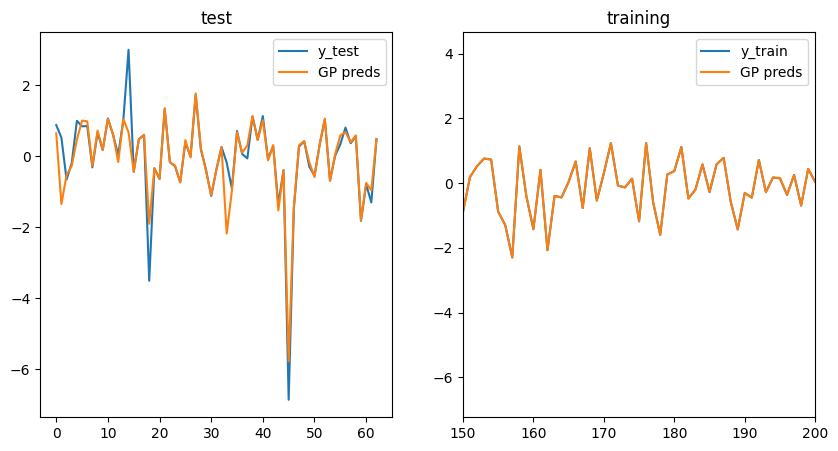

In [172]:
mean_preds_test = test_preds.mean.numpy()
mean_preds_train = train_preds.mean.numpy()

fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

ax[0].plot(range(y_test.shape[0]),y_test,label = "y_test")
ax[0].plot(range(y_test.shape[0]),mean_preds_test,label = "GP preds")
ax[0].legend();
ax[0].set_title("test");

ax[1].plot(range(y_train.shape[0]),y_train,label = "y_train")
ax[1].plot(range(y_train.shape[0]),mean_preds_train,label = "GP preds")
ax[1].set_xlim([150,200]);
ax[1].legend();
ax[1].set_title("training");


# RF-GP

In [ ]:
S = 500                                   # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [ ]:
def model_RFGP(X, Y=None, Omega_fixed=Omega_fixed, X_test=None, predict = False):
    N = X.shape[0]
    DIM = X.shape[1]
    S = Omega_fixed.shape[0]  # number of spectral frequencies

    var = numpyro.sample("var", dist.HalfNormal(scale=1))
    length = numpyro.sample("length", dist.HalfNormal(scale=jnp.ones((DIM,))))
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    Omega = Omega_fixed / length  # shape = (S,DIM)
    ########
    # assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(
        Omega
    )  # this is batch matmul: (Ndata,DIM) x (DIM,S) = (Ndata,S)
    # assert ola.shape == (M,N,S)
    Phi = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=1
    )  # tiene shape = (Ndata, 2*S)
    Phi = 1 / jnp.sqrt(S) * Phi  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi.shape == (N, 2 * S)

    theta = numpyro.sample(
        "theta", dist.Normal(jnp.zeros((2 * S,)), jnp.ones((2 * S,)))
    )
    # print(theta.shape)
    assert theta.shape == (2 * S,)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta = jnp.tile(jnp.sqrt(var), 2 * S) * theta
    f = numpyro.deterministic("f", (Phi @ theta).squeeze())
    assert f.shape == (N,)
    with numpyro.plate("N", N):
        numpyro.sample(
            "obs", dist.Normal(loc=f, scale=jnp.sqrt(noise) * jnp.ones((N,))), obs=Y
        )
    if predict:
        Ntest = X_test.shape[0]
        aux = X_test @ jnp.transpose(Omega)  # this is batch matmul: (Ndata,DIM) x (DIM,S) = (Ndata,S)
        assert aux.shape == (Ntest,S)
        Phi_test = jnp.concatenate([jnp.sin(aux), jnp.cos(aux)], axis=1)  
        Phi_test = 1 / jnp.sqrt(S) * Phi_test  # se me habia olvidado dividir entre jnp.sqrt(S)
        assert Phi_test.shape == (Ntest,2*S)
        Sigma_inv = jnp.divide(jnp.matmul(jnp.transpose(Phi),Phi),noise) + jnp.divide(jnp.eye(2*S),var)
        assert Sigma_inv.shape == (2*S,2*S)
        var_test = jnp.diag(jnp.matmul(Phi_test,jnp.linalg.solve(Sigma_inv,Phi_test.T)) + noise*jnp.eye(Ntest))
        numpyro.deterministic("ys2_test",var_test)


## SVI first

In [ ]:
from numpyro.infer import SVI, Trace_ELBO


svi = SVI(
        model_RFGP,
        AutoDelta(model_RFGP, 
                  init_loc_fn = 
                  numpyro.infer.init_to_median,
                #   numpyro.infer.init_to_value
                #   (
                #       values={
                #           "var": 1,
                #           "length": 0.5*jnp.ones((X_train.shape[1],)),
                #           "noise": 0.5,
                #           })
                )
                          ,
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(5e-3)),
        loss=Trace_ELBO(),
    )



res = svi.run(
    random.PRNGKey(0),
    5000,
    X=X_train,
    Y=y_train,
)

params = res.params

In [ ]:
print("lengthscales: ", params["length_auto_loc"])
print("signal var: ", params["var_auto_loc"])
print("noise var: ", params["noise_auto_loc"])

In [ ]:
from numpyro.infer import Predictive
guide = AutoDelta(model_RFGP)
# use guide to make predictive
num_samples = 1
dist_posterior_predictive = Predictive(model=model_RFGP, 
                                       guide=guide, params=params, num_samples=num_samples)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(1), 
                                                         X=X_test, Y=None, X_test=X_test, predict=True)

ymu_test = samples_posterior_predictive["f"]
ys2_test = samples_posterior_predictive["ys2_test"]
print("Av lpd test", (-0.5*(ymu_test-y_test)**2/ys2_test - 0.5*np.log(2*jnp.pi*ys2_test)).mean())
print("MSE test: ", ((ymu_test-y_test)**2).mean())

In [ ]:
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(1), 
                                                         X=X_train, Y=None, X_test=X_train, predict=True)

ymu_train = samples_posterior_predictive["f"]
ys2_train = samples_posterior_predictive["ys2_test"]
print("Av lpd train", (-0.5*(ymu_train-y_train)**2/ys2_train - 0.5*np.log(2*jnp.pi*ys2_train)).mean())
print("MSE train: ", ((ymu_train-y_train)**2).mean())

Actually, we don't need to sample the theta's as we are currently doing in model_rfgp above...
Indeed, we just need to build the Phi matrix to be able to evaluate the likelihood of the model.
We are artificially increasing the dimension of the model...

## Alternative RF-GP model where we don't sample theta

In [ ]:
S = 500                                 # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [ ]:
def other_RFGP(X, Y=None, Omega_fixed=Omega_fixed, X_test=None, predict = False):
    N = X.shape[0]
    DIM = X.shape[1]
    S = Omega_fixed.shape[0]  # number of spectral frequencies

    var = numpyro.sample("var", dist.HalfNormal(scale=1))
    length = numpyro.sample("length", dist.HalfNormal(scale=jnp.ones((DIM,))))
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    Omega = Omega_fixed / length  # shape = (S,DIM)
    ########
    # assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(
        Omega
    )  # this is batch matmul: (Ndata,DIM) x (DIM,S) = (Ndata,S)
    # assert ola.shape == (M,N,S)
    Phi = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=1
    )  # tiene shape = (Ndata, 2*S)
    Phi = 1 / jnp.sqrt(S) * Phi  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi.shape == (N, 2 * S)

    cov_mat = var*jnp.matmul(Phi,Phi.T) + noise * jnp.eye(N)
    numpyro.sample(
         "obs", dist.MultivariateNormal(loc=jnp.zeros((N,)), 
                            covariance_matrix=cov_mat),
                            obs=Y
        )
    if predict:
        Ntest = X_test.shape[0]
        aux = X_test @ jnp.transpose(Omega)  # this is batch matmul: (Ndata,DIM) x (DIM,S) = (Ndata,S)
        assert aux.shape == (Ntest,S)
        Phi_test = jnp.concatenate([jnp.sin(aux), jnp.cos(aux)], axis=1)  
        Phi_test = 1 / jnp.sqrt(S) * Phi_test  # se me habia olvidado dividir entre jnp.sqrt(S)
        assert Phi_test.shape == (Ntest,2*S)
        Sigma_inv = jnp.divide(jnp.matmul(jnp.transpose(Phi),Phi),noise) + jnp.divide(jnp.eye(2*S),var)
        assert Sigma_inv.shape == (2*S,2*S)
        var_test = jnp.diag(jnp.matmul(Phi_test,jnp.linalg.solve(Sigma_inv,Phi_test.T)) + noise*jnp.eye(Ntest))

        mu_test = jnp.matmul(Phi_test,jnp.linalg.solve(noise*Sigma_inv,jnp.matmul(Phi.T,Y)))

        numpyro.deterministic("ymu_test",mu_test)
        numpyro.deterministic("ys2_test",var_test)

In [ ]:
from numpyro.infer import SVI, Trace_ELBO


svi = SVI(
        other_RFGP,
        AutoDelta(other_RFGP, 
                  init_loc_fn = 
                #   numpyro.infer.init_to_median,
                  numpyro.infer.init_to_value
                  (
                      values={
                          "var": 1,
                          "length": 0.5*jnp.ones((X_train.shape[1],)),
                          "noise": 0.25,
                          })
                )
                          ,
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(5e-3)),
        loss=Trace_ELBO(),
    )



res = svi.run(
    random.PRNGKey(0),
    2000,
    X=X_train,
    Y=y_train,
)

params = res.params

In [ ]:
params

In [ ]:
from numpyro.infer import Predictive
guide = AutoDelta(other_RFGP)
# use guide to make predictive
num_samples = 1
dist_posterior_predictive = Predictive(model=other_RFGP, 
                                       guide=guide, params=params, num_samples=num_samples)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(1), 
                                                         X=X_train, Y=y_train, X_test=X_test, predict=True)

ymu_test = samples_posterior_predictive["ymu_test"]
ys2_test = samples_posterior_predictive["ys2_test"]
print("Av lpd test", (-0.5*(ymu_test-y_test)**2/ys2_test - 0.5*np.log(2*jnp.pi*ys2_test)).mean())
print("MSE test: ", ((ymu_test-y_test)**2).mean())

In [ ]:
ys2_test

In [ ]:
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(1), 
                                                         X=X_train, Y=y_train, X_test=X_train, predict=True)
ymu_train = samples_posterior_predictive["ymu_test"]
ys2_train = samples_posterior_predictive["ys2_test"]
print("Av lpd train", (-0.5*(ymu_train-y_train)**2/ys2_train - 0.5*np.log(2*jnp.pi*ys2_train)).mean())
print("MSE train: ", ((ymu_train-y_train)**2).mean())

# PoGPE (actually, it is a "cheaper" version)

The variances of the experts are considered the same for all points, namely, we are not modeling
the log-variances with RF-GPs, as we proposed

In [58]:
S = 100                                  # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


# np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [59]:
def myfun(A,B):
    return (A @ B).squeeze()

matmul_vmapped = jax.vmap(myfun, in_axes=(0, 0))


def pogpe_with_RFGP_fixed_Omega(X, M=2, Omega_fixed = Omega_fixed, Y=None, Ytest=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    S = Omega_fixed.shape[0]    # number of spectral frequencies

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        # noise_mu_ex = numpyro.sample("kernel_noise_exp_mean", dist.InverseGamma(5.0, 5.0))
        std_ex_un = numpyro.sample('std_ex_un', dist.InverseGamma(5.0, 5.0))
        std_ex = numpyro.deterministic('std_ex', jnp.tile(jnp.reshape(std_ex_un, (-1, 1)), N))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 1.0))

            
    assert lengthscale_ex.shape == (M,DIM)
    assert Omega_fixed.shape == (S,DIM)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))                                                                                                                            
    Omega_ex = vdivide( Omega_fixed, lengthscale_ex)     # shape = (M,S,DIM)
    ########
    assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_ex = 1/jnp.sqrt(S)*Phi_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_ex.shape == (M, N, 2*S)
    assert std_ex.shape == (M,N)
    assert theta_mu_ex.shape == (M,2*S)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_ex,theta_mu_ex) )                 # shape = (M,Ndata)
    assert mu_ex.shape == (M,N)



    #########################
    # RF-GP for log weights #
    #########################
    with numpyro.plate("M", M, dim=-2):
        # set uninformative log-normal priors on our three kernel hyperparameters
        var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
        # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

        with numpyro.plate('2S', 2*S):
            theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with numpyro.plate("DIM", DIM):
            lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1.0))

    assert lengthscale_logw.shape == (M,DIM)

    # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    assert theta_logw.shape == (M,2*S)


    Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # ESTO ES NUEVO: QUIERO INCLUIR UN RUIDO GAUSSIANO AL FINAL DE LA FUSION
    # std_noise_un = numpyro.sample('std_noise_un', dist.Gamma(1.0, 0.5))
    # std_noise = numpyro.deterministic('std_noise', jnp.tile(jnp.reshape(std_noise_un, (-1, 1)), N))
    

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + jnp.squeeze(std_noise)**2),  # NUEVO
                    ),
        obs=Y,
    )

    if Ytest is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(Ytest), 
                loc=jnp.squeeze(mu_fused), 
                scale=jnp.squeeze(std_fused),
                # scale = jnp.sqrt(jnp.squeeze(std_fused)**2 + jnp.squeeze(std_noise)**2),  # NUEVO
                )
            )


In [276]:
%%script true
from numpyro.handlers import seed, trace

exec_trace = trace(seed(pogpe_with_RFGP_fixed_Omega, random.PRNGKey(0))).get_trace(X_train)
print(exec_trace.keys())

## SVI

100%|██████████| 5000/5000 [00:11<00:00, 427.85it/s, init loss: 1608.7687, avg. loss [4751-5000]: 603.8149]


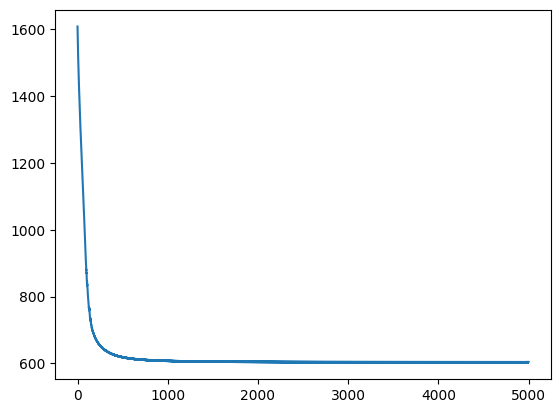

In [283]:
svi= SVI(
        pogpe_with_RFGP_fixed_Omega,
        AutoDelta(pogpe_with_RFGP_fixed_Omega, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam (overfitting is huge with this optimizer...)
        optim=chain(clip(10.0), adam(0.01)),
        # optim=adam(0.001),
        loss=Trace_ELBO(),
    )

num_models = 2

res_pogpe = svi.run(
    random.PRNGKey(4),
    # 20,
    5000,  # for adam
    X=X_train,
    Y=y_train,
    M=num_models,
)
plt.plot(res_pogpe[2]);

In [284]:
params = res_pogpe.params
guide = AutoDelta(pogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=pogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=1)
# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_test, 
                                                         Y=None, 
                                                         M=num_models,
                                                         Ytest=y_test)
ymu_tst_svi = samples_posterior_predictive["mean_fused"].squeeze()
ys2_tst_svi = samples_posterior_predictive["std_fused"].squeeze()
ymu_ex_tst = samples_posterior_predictive["mu_ex"].squeeze()
w_pogpe_tst = samples_posterior_predictive["w"].squeeze()


lpd_pogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
mse_pogpe_svi_test = np.mean((ymu_tst_svi-y_test)**2)

# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_train, 
                                                         Y=None, 
                                                         M=num_models,
                                                         Ytest=y_train)
ymu_tr_svi = samples_posterior_predictive["mean_fused"].squeeze()
ymu_ex_tr = samples_posterior_predictive["mu_ex"].squeeze()
w_pogpe_tr = samples_posterior_predictive["w"].squeeze()


lpd_pogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
mse_pogpe_svi_train = np.mean((ymu_tr_svi-y_train)**2)

print("MLPD test: ", lpd_pogpe_svi_test)
print("MLPD train: ", lpd_pogpe_svi_train)
print("MSE test: ", mse_pogpe_svi_test)
print("MSE train: ", mse_pogpe_svi_train)

MLPD test:  -1.0077220032802972
MLPD train:  0.6071482171193273
MSE test:  0.6498338796979839
MSE train:  0.1697893562494892


### plots of fused and individual expert predictions on training and test data

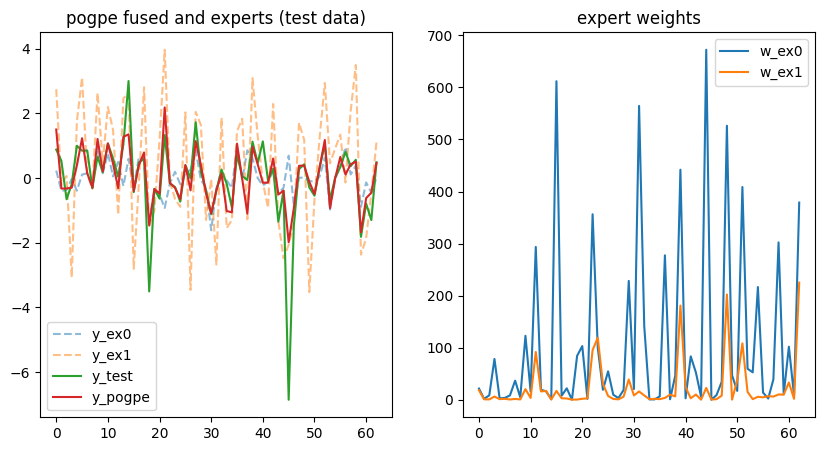

In [285]:
fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)
N=y_test.shape[0]
for i in range(num_models):
    ax[0].plot(range(N), ymu_ex_tst[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(range(N), y_test,label="y_test")
ax[0].plot(range(N), ymu_tst_svi,label="y_pogpe")

ax[0].legend();
ax[0].set_title("pogpe fused and experts (test data)");


for i in range(num_models):
    ax[1].plot(range(N), w_pogpe_tst[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();   


(150.0, 200.0)

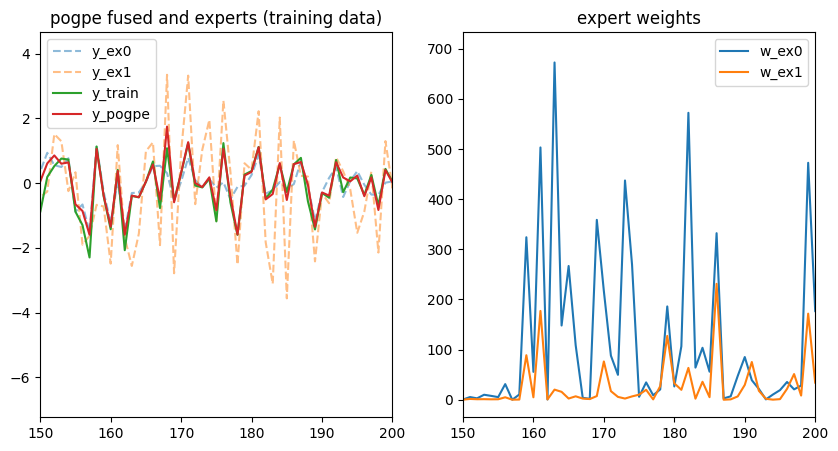

In [286]:
fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)

N=y_train.shape[0]
for i in range(num_models):
    ax[0].plot(range(y_train.shape[0]), ymu_ex_tr[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(range(N), y_train,label="y_train",alpha = 1)
ax[0].plot(range(N), ymu_tr_svi,label="y_pogpe",alpha = 1)

ax[0].legend();
ax[0].set_title("pogpe fused and experts (training data)");
ax[0].set_xlim([150,200])


for i in range(num_models):
    ax[1].plot(range(N), w_pogpe_tr[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();
ax[1].set_xlim([150,200])   

## MCMC

In [305]:
# We sample the model using NUTS

pogpe_kernel = NUTS(pogpe_with_RFGP_fixed_Omega,
                    max_tree_depth=2,
                    # max_tree_depth=(10,5),
                    # find_heuristic_step_size=True,
                    # init_strategy=numpyro.infer.init_to_median,
                    init_strategy = numpyro.infer.initialization.init_to_value(
                      values={
"kernel_var_exp_mean": params['kernel_var_exp_mean_auto_loc'],
"kernel_var_logw": params["kernel_var_logw_auto_loc"],
"ell_ex": params["ell_ex_auto_loc"],
"ell_logw": params["ell_logw_auto_loc"],
"theta_mu_ex": params["theta_mu_ex_auto_loc"],
"theta_logw": params["theta_logw_auto_loc"],
"std_ex_un": params["std_ex_un_auto_loc"]
                          }),
                          )   
pogpe_mcmc = MCMC(
    pogpe_kernel,
      num_chains=4, 
      num_samples=1000, 
      num_warmup=1000, 
      thinning=1,
      progress_bar=True,
    chain_method="parallel",
)


pogpe_mcmc.run(
    random.PRNGKey(4),
    X_train,
    Y = y_train,
    Ytest = y_train # this is line is for computing the lpd of y_train
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [306]:
samples_pogpe = pogpe_mcmc.get_samples()
pogpe_mcmc.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
             ell_ex[0,0]      0.83      0.06      0.82      0.75      0.92      3.14      3.01
             ell_ex[0,1]      0.51      0.02      0.51      0.48      0.53      5.08      2.21
             ell_ex[0,2]      0.54      0.03      0.54      0.50      0.58      2.24      4.35
             ell_ex[0,3]      0.99      0.09      0.96      0.88      1.12      2.78      2.57
             ell_ex[0,4]      0.70      0.02      0.70      0.67      0.75      2.57      2.92
             ell_ex[0,5]      0.44      0.02      0.44      0.42      0.46      7.45      1.43
             ell_ex[0,6]      0.31      0.01      0.31      0.30      0.32      3.57      2.24
             ell_ex[0,7]      0.59      0.02      0.59      0.56      0.61      2.16      4.03
             ell_ex[0,8]      0.42      0.02      0.41      0.40      0.45      2.16      5.08
             ell_ex[1,0]      0.83      0.05     

Evaluating the performance: mean of the evaluations of the logpredictive on the training and test dataset

In [307]:
# lpd on training data 
lpd_pogpe_train = jax.nn.logsumexp(
    samples_pogpe["lpd_point"] - np.log(samples_pogpe["lpd_point"].shape[0]), axis=0) 

print("MLPD on training data: ", np.mean(lpd_pogpe_train), lpd_pogpe_train.shape)

# plt.plot(lpd_pogpe_train);

MLPD on training data:  0.6921709165379702 (567,)


In [308]:
predict_pogpe = numpyro.infer.Predictive(pogpe_with_RFGP_fixed_Omega, samples_pogpe)
preds_test_pogpe = predict_pogpe(random.PRNGKey(11), 
                X_test, 
                Y = None,
                Ytest = y_test, # this line is for computing the lpd of y_test
                )


# lps of test data
lpd_pogpe_test = jax.nn.logsumexp(preds_test_pogpe["lpd_point"] - np.log(preds_test_pogpe["lpd_point"].shape[0]) ,axis=0) 
print("MLPD on test data: ", np.mean(lpd_pogpe_test),lpd_pogpe_test.shape)
# plt.plot(lpd_pogpe_test)

MLPD on test data:  -0.6207941052335814 (63,)


In [309]:
# computing the MSE of pogpe on training and test data

ymu_tr_pogpe = samples_pogpe["mean_fused"].mean(0)
ymu_tst_pogpe = preds_test_pogpe["mean_fused"].mean(0)

mse_pogpe_mcmc_test = np.mean((ymu_tst_pogpe-y_test)**2)
mse_pogpe_mcmc_train = np.mean((ymu_tr_pogpe-y_train)**2)

print("MSE on test data: ", mse_pogpe_mcmc_test)
print("MSE on training data: ", mse_pogpe_mcmc_train)

MSE on test data:  0.704278116207282
MSE on training data:  0.17561733664433374


## Comparing SVI and MCMC results


In [310]:
print("MLPD test (mcmc vs svi): ", lpd_pogpe_test.mean(), lpd_pogpe_svi_test.mean())
print("MLPD train (mcmc vs svi): ", lpd_pogpe_train.mean(), lpd_pogpe_svi_train.mean())
print('==============================================')
print("MSE test (mcmc vs svi): ", mse_pogpe_mcmc_test, mse_pogpe_svi_test)
print("MSE train (mcmc vs svi): ", mse_pogpe_mcmc_train, mse_pogpe_svi_train)

MLPD test (mcmc vs svi):  -0.6207941052335814 -1.0077220032802972
MLPD train (mcmc vs svi):  0.6921709165379702 0.6071482171193273
MSE test (mcmc vs svi):  0.704278116207282 0.6498338796979839
MSE train (mcmc vs svi):  0.17561733664433374 0.1697893562494892


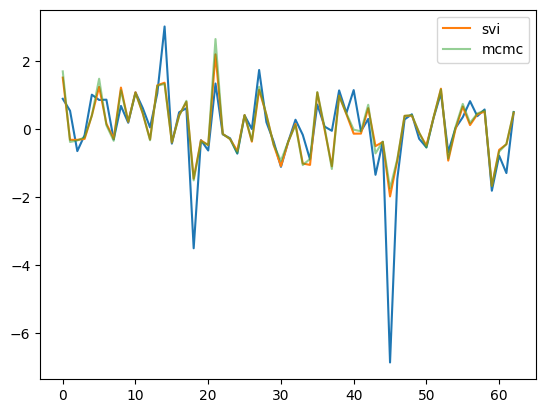

In [311]:
plt.plot(range(y_test.shape[0]), y_test)
plt.plot(range(y_test.shape[0]), ymu_tst_svi.squeeze(), label = "svi", alpha=1)
plt.plot(range(y_test.shape[0]), ymu_tst_pogpe, label = "mcmc", alpha=0.5)
plt.legend();


# "Trully" PoGPE: variances of the experts are also RF-GPs

In [ ]:
S = 50                                  # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [ ]:
def myfun(A,B):
    return (A @ B).squeeze()

matmul_vmapped = jax.vmap(myfun, in_axes=(0, 0))


def trully_pogpe_with_RFGP_fixed_Omega(X, M=2, Omega_fixed = Omega_fixed, Y=None, Ytest=None):              # M is the number of experts
    
    
    N = X.shape[0]
    DIM = X.shape[1]
    S = Omega_fixed.shape[0]    # number of spectral frequencies

    assert Omega_fixed.shape == (S,DIM)
   
    ##############################################
    # RF-GP for the experts's mean and log-std   #
    ##############################################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        var_logstd_ex = numpyro.sample("kernel_var_exp_logstd", dist.HalfNormal(1.0))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample('theta_logstd_ex', dist.Normal(loc=0.0, 
                                                        scale=1.0))
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_mu_ex = numpyro.sample('ell_mu_ex', dist.HalfNormal(scale = 1))
            lengthscale_logstd_ex = numpyro.sample('ell_logstd_ex', dist.HalfNormal(scale = 1))

            
    assert lengthscale_mu_ex.shape == (M,DIM)
    assert lengthscale_logstd_ex.shape == (M,DIM)
    assert theta_mu_ex.shape == (M,2*S)
    assert theta_logstd_ex.shape == (M,2*S)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))       
    #
    # =============== EXPERTS' MEANS  =============== #                                                                                                                   
    Omega_mu_ex = vdivide( Omega_fixed, lengthscale_mu_ex)     # shape = (M,S,DIM)
    assert Omega_mu_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_mu_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_mu_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1/jnp.sqrt(S)*Phi_mu_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_mu_ex.shape == (M, N, 2*S)
    #
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_mu_ex,theta_mu_ex) )    
    assert mu_ex.shape == (M,N)
    # ========================================== #

    # =============== EXPERTS' LOGSTDS  =============== #                                                                                                                   
    Omega_logstd_ex = vdivide( Omega_fixed, lengthscale_logstd_ex)     # shape = (M,S,DIM)
    assert Omega_logstd_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logstd_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_logstd_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1/jnp.sqrt(S)*Phi_logstd_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_logstd_ex.shape == (M, N, 2*S)
    #
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd_ex),2*S) * theta_logstd_ex
    logstd_ex = numpyro.deterministic("logstd_ex", matmul_vmapped(Phi_logstd_ex,theta_logstd_ex) )   
    std_ex =  numpyro.deterministic("std_ex", jnp.exp(logstd_ex) )
    assert logstd_ex.shape == (M,N)
    assert std_ex.shape == (M,N)
    # ========================================== #
    
    # =========  EXPERTS' LOGWEIGHTS ================= #
    with numpyro.plate("M", M, dim=-2):
        # set uninformative log-normal priors on our three kernel hyperparameters
        var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
        # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

        with numpyro.plate('2S', 2*S):
            theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with numpyro.plate("DIM", DIM):
            lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1))

    assert lengthscale_logw.shape == (M,DIM)

    # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    assert theta_logw.shape == (M,2*S)


    Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    assert logw.shape == (M,N)
    # ======================================== #

    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused)),
        obs=Y,
    )

    if Ytest is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(Ytest), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )


In [ ]:
# We sample the model using NUTS

trully_pogpe_kernel = NUTS(trully_pogpe_with_RFGP_fixed_Omega, max_tree_depth=5)   
trully_pogpe_mcmc = MCMC(
    trully_pogpe_kernel, num_chains=4, num_samples=500, num_warmup=500, thinning=1,progress_bar=True,
    chain_method="parallel"
)


trully_pogpe_mcmc.run(
    random.PRNGKey(26),
    X_train,
    Y = y_train,
    Ytest = y_train # this is line is for computing the lpd of y_train
)

samples_trully_pogpe = trully_pogpe_mcmc.get_samples()
trully_pogpe_mcmc.print_summary()


In [ ]:
predict_trully_pogpe = numpyro.infer.Predictive(trully_pogpe_with_RFGP_fixed_Omega, samples_trully_pogpe)
preds_test_trully_pogpe = predict_trully_pogpe(random.PRNGKey(24), 
                X_test, 
                Y = None,
                Ytest = y_test, # this line is for computing the lpd of y_test
                )


In [ ]:
# lpd on training data 
lpd_trully_pogpe_train = jax.nn.logsumexp(
    samples_trully_pogpe["lpd_point"] - np.log(samples_trully_pogpe["lpd_point"].shape[0]), axis=0) 

print("Av lpd on train: ", np.mean(lpd_trully_pogpe_train))

# lps of test data
lpd_trully_pogpe_test = jax.nn.logsumexp(preds_test_trully_pogpe["lpd_point"] - \
                                         np.log(preds_test_trully_pogpe["lpd_point"].shape[0]) ,axis=0) 
print("Av lpd on test: ", np.mean(lpd_trully_pogpe_test))
# plt.plot(lpd_pogpe_test)


In [ ]:
# computing the MSE of pogpe on training and test data

ymu_tr_trully_pogpe = samples_trully_pogpe["mean_fused"].mean(0)
ymu_tst_trully_pogpe = preds_test_trully_pogpe["mean_fused"].mean(0)

print("MSE on test data: ", np.mean((ymu_tst_trully_pogpe-y_test)**2))
print("MSE on training data: ", np.mean((ymu_tr_trully_pogpe-y_train)**2))

## SVI on trully-pogpe

In [ ]:
svi_trully_pogpe = SVI(
        trully_pogpe_with_RFGP_fixed_Omega,
        AutoDelta(trully_pogpe_with_RFGP_fixed_Omega, 
                  init_loc_fn = numpyro.infer.init_to_median),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(0.01)),
        loss=Trace_ELBO(),
    )



res_trully_pogpe = svi_trully_pogpe.run(
    random.PRNGKey(0),
    5000,
    X=X_train,
    Y=y_train,
)

# print(res_trully_pogpe.params)

In [ ]:
from numpyro.infer import Predictive
params = res_trully_pogpe.params
guide = AutoDelta(trully_pogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
num_samples = 1
dist_posterior_predictive = Predictive(model=trully_pogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=num_samples)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(1), X=X_test, Y=None, Ytest=y_test)
print("Av lpd test",samples_posterior_predictive["lpd_point"].mean())
ymu_tst_svi = samples_posterior_predictive["mean_fused"].mean(0)

In [ ]:
# approach 2, for train data (e.g. to asess model fit)
num_samples = 1
dist_posterior_predictive = Predictive(model=trully_pogpe_with_RFGP_fixed_Omega,
                                        guide=guide, params=params, num_samples=num_samples)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(1), X=X_train, Y=None, Ytest=y_train)
print("Av lpd training",samples_posterior_predictive["lpd_point"].mean())
ymu_tr_svi = samples_posterior_predictive["mean_fused"].mean(0)

In [ ]:
# computing the MSE of pogpe on training and test data
print("MSE on test data: ", np.mean((ymu_tst_svi-y_test)**2))
print("MSE on training data: ", np.mean((ymu_tr_svi-y_train)**2))

In [ ]:
a = 'yacht'
print(f"{a}")

# MOGPE

In [265]:
S = 300                                  # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


# np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [266]:

def mogpe_with_RFGP_fixed_Omega(X, M=None, Omega_fixed=Omega_fixed, y_val=None):
    # M is the number of experts
    # S is the number of spectral frequencies = one half of number of basis functions
    S = Omega_fixed.shape[0]

    with numpyro.plate("M", M, dim=-2):
        var_mu = numpyro.sample("kernel_var_mu_ex", dist.HalfNormal(1.0))
        # noise_mu = numpyro.sample("kernel_noise_mu_ex",dist.InverseGamma(5.0, 5.0))

        var_logstd = numpyro.sample("kernel_var_logstd_ex", dist.HalfNormal(1.0))
        # noise_logstd = numpyro.sample("kernel_noise_logstd_ex",dist.InverseGamma(5.0, 5.0))

        with numpyro.plate("2S", 2 * S):
            theta_mu_ex = numpyro.sample(
                "theta_mu_ex", dist.Normal(loc=0.0, scale=1.0)
            )  # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample(
                "theta_logstd_ex", dist.Normal(loc=0.0, scale=1.0)
            )  # I'm not considering signal power here!
        with numpyro.plate("DIM", DIM):
            lengthscale_mu_ex = numpyro.sample("ell_mu_ex", dist.HalfNormal(scale=5.0))
            lengthscale_logstd_ex = numpyro.sample(
                "ell_logstd_ex", dist.HalfNormal(scale=1)
            )

    #### MU EX
    vdivide = jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))
    Omega_mu_ex = vdivide(Omega_fixed, lengthscale_mu_ex)  # shape = (M,S,DIM)
    ########
    # assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(
        Omega_mu_ex, axes=(0, 2, 1)
    )  # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    # assert ola.shape == (M,N,S)
    Phi_mu_ex = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=2
    )  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1 / jnp.sqrt(S) * Phi_mu_ex

    #### LOGSTD EX
    Omega_logstd_ex = vdivide(Omega_fixed, lengthscale_logstd_ex)
    ola = X @ jnp.transpose(
        Omega_logstd_ex, axes=(0, 2, 1)
    )  # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    # assert ola.shape == (M,N,S)
    Phi_logstd_ex = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=2
    )  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1 / jnp.sqrt(S) * Phi_logstd_ex

    assert var_mu.shape == (M, 1)
    assert theta_mu_ex.shape == (M, 2 * S)

    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu), 2 * S) * theta_mu_ex
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd), 2 * S) * theta_logstd_ex

    mu_ex = numpyro.deterministic(
        "mu_ex", matmul_vmapped(Phi_mu_ex, theta_mu_ex)
    )  # shape = (M,Ndata)
    logstd_ex = numpyro.deterministic(
        "logstd_ex", matmul_vmapped(Phi_logstd_ex, theta_logstd_ex)
    )  # shape = (M,Ndata)
    std_ex = numpyro.deterministic("std_ex", jnp.exp(logstd_ex))  # shape = (M,Ndata)

    ################################
    # GP for unconstrained weights #
    ################################

    with numpyro.plate("M1", M - 1, dim=-2):
        var_w = numpyro.sample("kernel_var_w", dist.HalfNormal(1.0))
        with numpyro.plate("2S", 2 * S):
            theta_w = numpyro.sample(
                "theta_w",
                dist.Normal(
                    loc=0.0, scale=1.0
                ),  # I'm not considering signal power here!
            )
        with numpyro.plate("DIM", DIM):
            lengthscale_w = numpyro.sample("ell_w", dist.HalfNormal(scale=1))

    assert var_w.shape == (M - 1, 1)
    assert theta_w.shape == (M - 1, 2 * S)

    #### W_UN
    Omega_w = vdivide(Omega_fixed, lengthscale_w)
    ola = X @ jnp.transpose(Omega_w, axes=(0, 2, 1))
    Phi_w = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=2
    )  # tiene shape = (M, Ndata, 2*S)
    Phi_w = 1 / jnp.sqrt(S) * Phi_w

    theta_w = jnp.tile(jnp.sqrt(var_w), 2 * S) * theta_w
    w_un = matmul_vmapped(Phi_w, theta_w)  # shape = (M-1,Ndata)
    w_un = jnp.vstack([w_un, jnp.zeros(X.shape[0])])  # shape = (M,Ndata)

    log_w = jax.nn.log_softmax(w_un, axis=0)  # shape = (M,Ndata)

    # compute log-factor
    y_val_rep = jnp.tile(jnp.reshape(y_val, (-1, 1)), M)
    lpd_point = jax.scipy.stats.norm.logpdf(y_val_rep, loc=mu_ex.T, scale=std_ex.T)
    logp = jax.nn.logsumexp(lpd_point + log_w.T, axis=1)
    numpyro.deterministic(
        "lpd_point", logp
    )  # I store the evaluation of the log-likelihood
    numpyro.deterministic("w", jnp.exp(log_w).T)
    numpyro.factor("logp", jnp.sum(logp))  # shape = (Ndata, M)

## svi 

100%|██████████| 5000/5000 [00:36<00:00, 135.53it/s, init loss: 3777.9121, avg. loss [4751-5000]: 2649.1459]


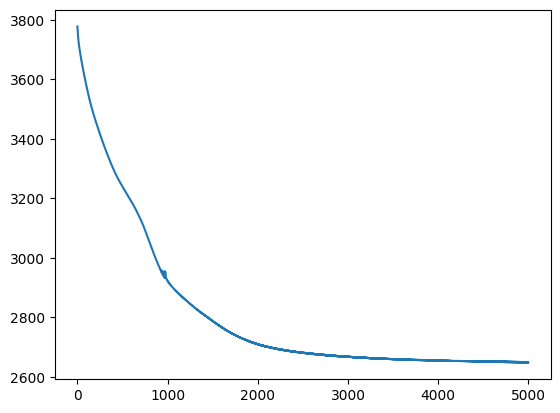

In [268]:
M_models=2
svi= SVI(
        mogpe_with_RFGP_fixed_Omega,
        AutoDelta(mogpe_with_RFGP_fixed_Omega, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(0.001)),
        loss=Trace_ELBO(),
    )

res_mogpe = svi.run(
    random.PRNGKey(0),
    # 5,
    5000,  # these many iterations when using adam optimizer
    X_train,
    y_val=y_train,
    M=M_models,
)

plt.plot(res_mogpe[2])


In [269]:
params = res_mogpe.params
guide = AutoDelta(mogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=mogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=1)
# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_test, 
                                                         y_val=y_test, 
                                                         M=M_models,
                                                         )
ymu_experts = samples_posterior_predictive["mu_ex"].squeeze()  # tiene shape (M_models, y_test.shape[0])
w_experts_test = samples_posterior_predictive["w"].squeeze()   # tiene shape (y_test.shape[0], M_models)

ymu_mogpe = jnp.sum(jnp.multiply(ymu_experts,w_experts_test.T),axis=0)

lpd_mogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
mse_mogpe_svi_test = np.mean((ymu_mogpe-y_test)**2)

print("MLPD test data: ", lpd_mogpe_svi_test)
print("MSE test data: ", mse_mogpe_svi_test)

MLPD test data:  -1.0316923275641414
MSE test data:  1.2198353884567696


In [270]:
# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_train, 
                                                         y_val=y_train, 
                                                         M=M_models,
                                                         )
ymu_experts_train = samples_posterior_predictive["mu_ex"].squeeze()  # tiene shape (M_models, y_test.shape[0])
w_experts_train = samples_posterior_predictive["w"].squeeze()   # tiene shape (y_test.shape[0], M_models)

ymu_mogpe_train = jnp.sum(jnp.multiply(ymu_experts_train,w_experts_train.T),axis=0)

lpd_mogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
mse_mogpe_svi_train = np.mean((ymu_mogpe_train-y_train)**2)

print("MLPD training data: ", lpd_mogpe_svi_train)
print("MSE training data: ", mse_mogpe_svi_train)

MLPD training data:  0.7101290084333485
MSE training data:  0.4709950745817577


### plots of fused and individual expert predictions on training and test data

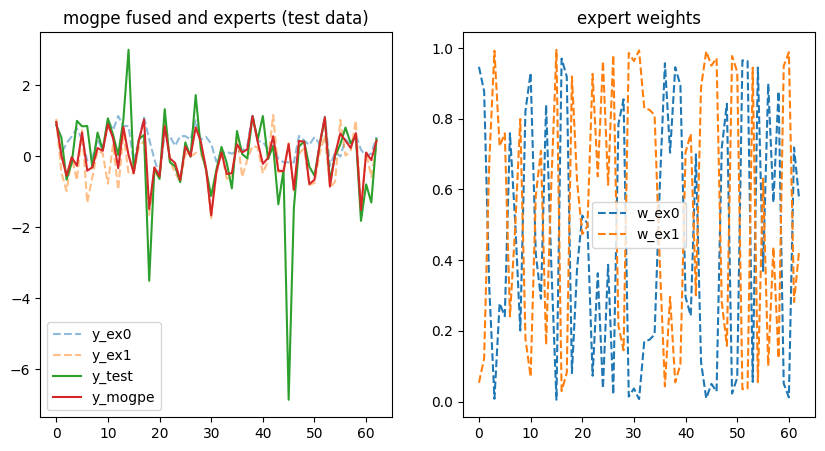

In [271]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(M_models):
    ax[0].plot(range(y_test.shape[0]), ymu_experts[i,:],'--',label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(range(y_test.shape[0]), y_test,label="y_test",alpha=1)
ax[0].plot(range(y_test.shape[0]), ymu_mogpe,label="y_mogpe",alpha=1)
ax[0].legend();
ax[0].set_title("mogpe fused and experts (test data)")


for i in range(M_models):
    ax[1].plot(range(y_test.shape[0]), w_experts_test[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights");

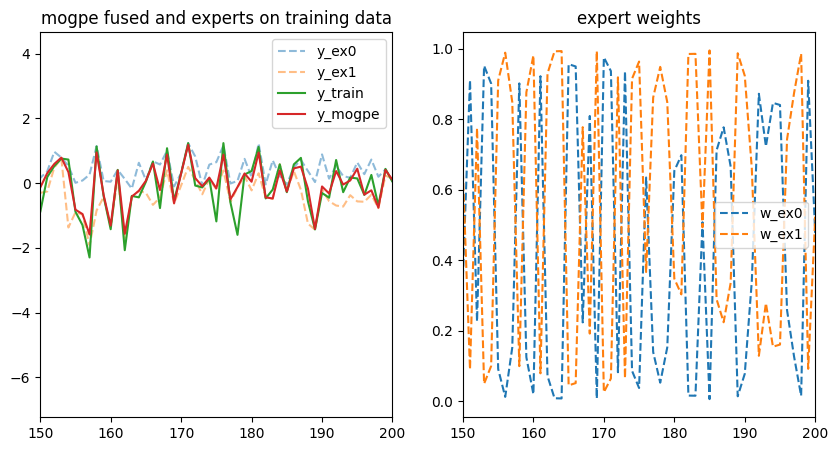

In [272]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(M_models):
    ax[0].plot(range(y_train.shape[0]), ymu_experts_train[i,:],'--',label=f"y_ex{i}",alpha = 0.5)


ax[0].plot(range(y_train.shape[0]), y_train,label="y_train",alpha=1)
ax[0].plot(range(y_train.shape[0]), ymu_mogpe_train,label="y_mogpe",alpha=1)
ax[0].legend();
ax[0].set_title("mogpe fused and experts on training data")
ax[0].set_xlim([150,200]);

for i in range(M_models):
    ax[1].plot(range(y_train.shape[0]), w_experts_train[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights")
ax[1].set_xlim([150,200]);

## mcmc


In [ ]:


miMCMC = NUTS(
    mogpe_with_RFGP_fixed_Omega,
    max_tree_depth=2,
    # find_heuristic_step_size=True,
    init_strategy=numpyro.infer.initialization.init_to_median,
)

fer = MCMC(
    miMCMC,
    num_chains=4,
    num_samples=500,
    num_warmup=500,
    thinning=1,
    progress_bar=True,
    chain_method="parallel",
)
M_models = 2
fer.run(
    random.PRNGKey(0),
    X_train,
    y_val=y_train,
    M=M_models,
)

miSamples_mogpe = fer.get_samples()
fer.print_summary()

In [ ]:

lpd_mogpe_train = jax.nn.logsumexp(miSamples_mogpe["lpd_point"], axis=0) - np.log(
    miSamples_mogpe["lpd_point"].shape[0]
)
predict = numpyro.infer.Predictive(mogpe_with_RFGP_fixed_Omega, miSamples_mogpe)
preds = predict(
    random.PRNGKey(0),
    X_test,
    y_val=y_test,
    M=M_models,
)
lpd_mogpe_test = jax.nn.logsumexp(preds["lpd_point"], axis=0) - np.log(
    preds["lpd_point"].shape[0]
)

In [ ]:
print(lpd_mogpe_train.mean(0))
print(lpd_mogpe_test.mean(0))

In [ ]:
preds["w"].shape